# Importing libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
from torchvision import models
import cv2 as op

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

/tmp/ipykernel_32/3435668452.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


('1.23.5', 'cuda')

# Loading the Datasets

In [46]:
TRAIN_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Train'
TEST_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))
            
    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })
    
    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape
print(df_train['fruit'].unique())
print(df_test['fruit'].unique())


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

['tomato' 'banana' 'okra' 'cucumber' 'apples' 'potato' 'oranges'
 'bittergroud' 'capsicum']
['tamto' 'banana' 'apples' 'oranges' 'okra' 'cucumber' 'patato']


In [47]:
# Drop 'apples', 'bittergourd', and 'okra' from the training set
df_train = df_train[~df_train['fruit'].isin(['apples', 'bittergroud', 'okra'])]

# Drop 'apples' and 'okra' from the test set
df_test = df_test[~df_test['fruit'].isin(['apples', 'okra'])]

# Correct spelling issues in the test set
df_test['fruit'] = df_test['fruit'].map(lambda x: 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x: 'potato' if x == 'patato' else x)


print(df_train['fruit'].unique())
print(df_test['fruit'].unique())

['tomato' 'banana' 'cucumber' 'potato' 'oranges' 'capsicum']
['tomato' 'banana' 'oranges' 'cucumber' 'potato']


In [48]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(20655, 3)

# Data distribution

       fruit  fresh  count
0     banana      0   3360
1     banana      1   3832
2   capsicum      0    990
3   capsicum      1    901
4   cucumber      0    775
5   cucumber      1    676
6    oranges      0   1854
7    oranges      1   1998
8     potato      0    806
9     potato      1   1172
10    tomato      0   2113
11    tomato      1   2178


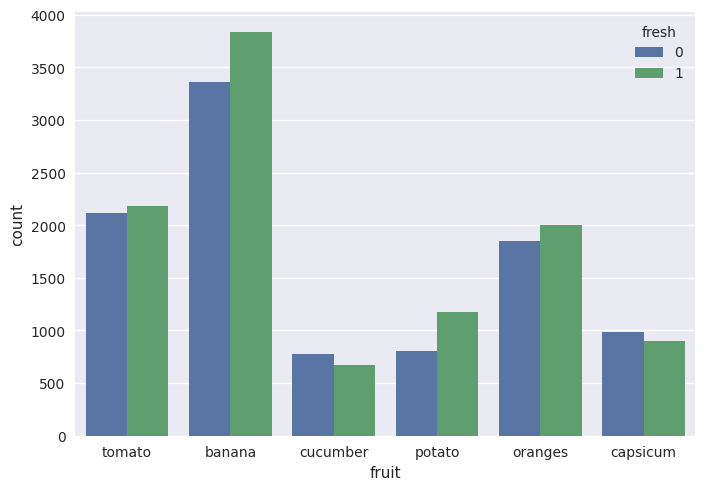

In [54]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')
# Get the count of samples for each fruit and freshness category
class_distribution = df.groupby(['fruit', 'fresh']).size().reset_index(name='count')

# Display the distribution
print(class_distribution)


# Generate a New balanced dataset

In [55]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 1500:
        df_temp = df[df['fruit'] == key].sample(n = 800)
    else:
        df_temp = df[df['fruit'] == key]
        
    df_new = pd.concat([df_new, df_temp], axis = 0)  
    
df_new.shape# Set the maximum number of samples per class (800 or 900)
max_samples = 800

# Create a new DataFrame for the balanced dataset
df_new = pd.DataFrame(columns=['filename', 'fruit', 'fresh'])

# Loop through each fruit and take a random sample of up to 800 samples
for (key, value) in counts.items():
    if value > max_samples:
        df_temp = df[df['fruit'] == key].sample(n=max_samples)  # Take max_samples if the class has more
    else:
        df_temp = df[df['fruit'] == key]  # Include all samples if class has less than max_samples
    
    # Concatenate the sampled data into df_new
    df_new = pd.concat([df_new, df_temp], axis=0)

# Shuffle the new dataset and reset the index
df_new = df_new.sample(frac=1).reset_index(drop=True)

# Check the shape and distribution
print(df_new.shape)
print(df_new['fruit'].value_counts())


(4800, 3)
fruit
banana      800
capsicum    800
potato      800
oranges     800
cucumber    800
tomato      800
Name: count, dtype: int64


In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_new['fruit_label'] = le.fit_transform(df_new['fruit'])
df_new.shape

(4800, 4)

In [57]:
df_new.head()

filename     fruit fresh  \
0  /kaggle/input/fresh-and-stale-classification/d...    banana     1   
1  /kaggle/input/fresh-and-stale-classification/d...  capsicum     1   
2  /kaggle/input/fresh-and-stale-classification/d...  capsicum     0   
3  /kaggle/input/fresh-and-stale-classification/d...    potato     0   
4  /kaggle/input/fresh-and-stale-classification/d...    banana     0   

   fruit_label  
0            0  
1            1  
2            1  
3            4  
4            0

<Axes: xlabel='fruit', ylabel='count'>

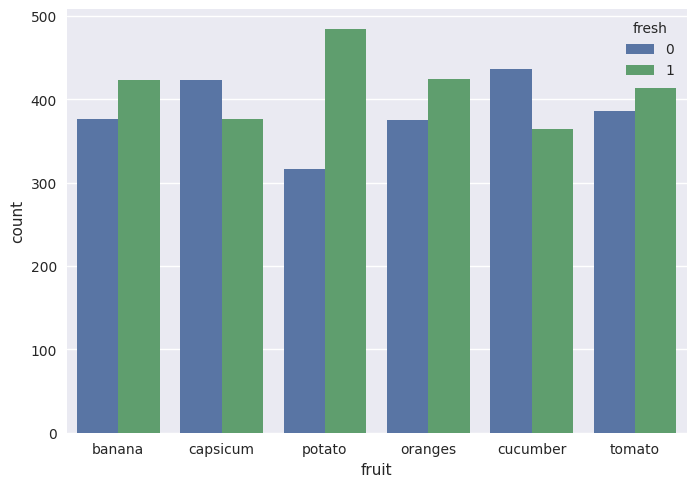

In [58]:
sea.countplot(x = 'fruit', data = df_new, hue = 'fresh')

# Trainning and Validation split

- 15% of the data was used for validation set.

In [59]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_new, test_size = 0.15, stratify = df_new['fruit_label'])

df_train.shape, df_val.shape

((4080, 4), (720, 4))

<Axes: xlabel='fruit_label', ylabel='count'>

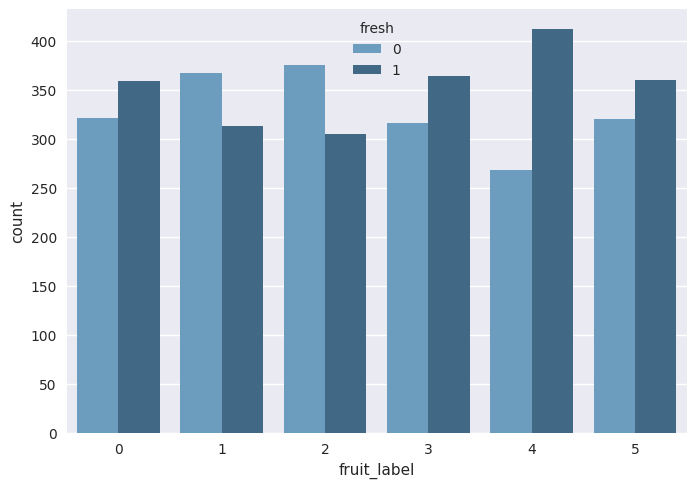

In [60]:
sea.countplot(x = 'fruit_label', data = df_train, hue = 'fresh', palette = 'Blues_d')

<Axes: xlabel='fruit', ylabel='count'>

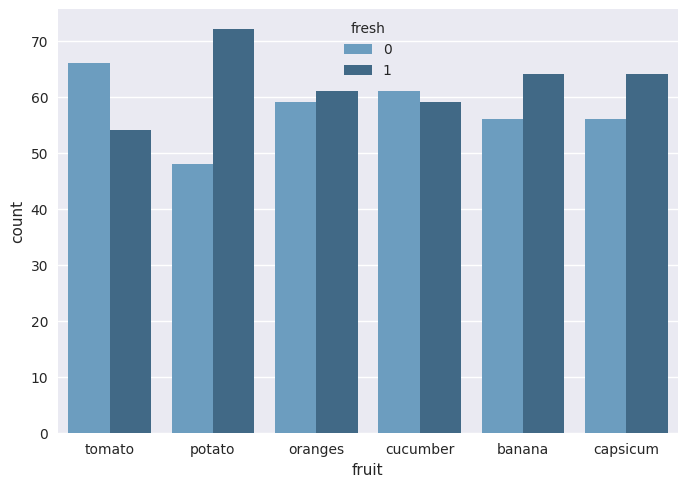

In [61]:
sea.countplot(x = 'fruit', data = df_val, hue = 'fresh', palette = 'Blues_d')

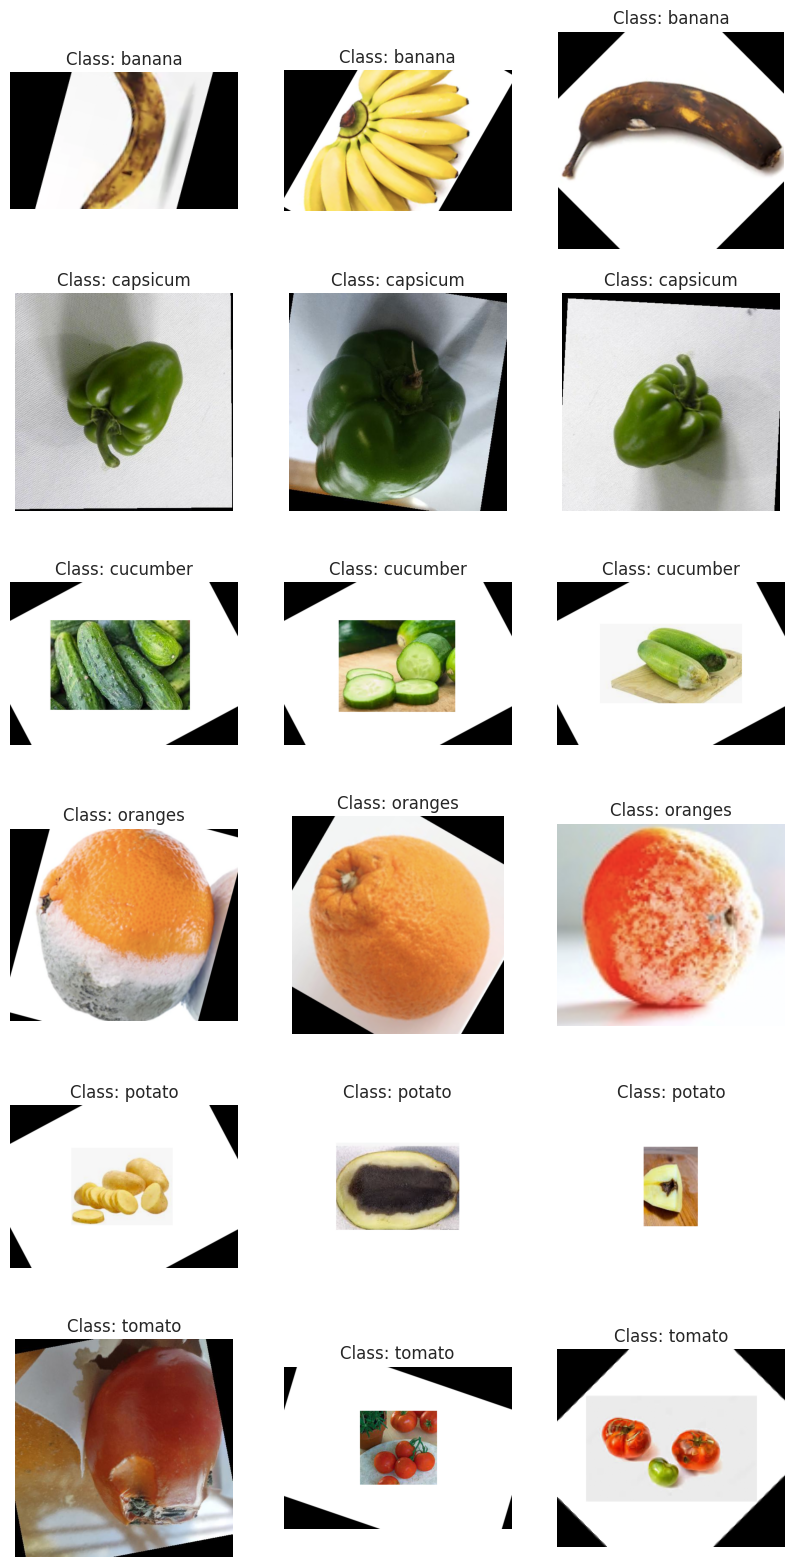

In [64]:
def load_image(path):
    img = plt.imread(path)
    return img

counter = 0

plt.figure(figsize=(10, 30))

# Loop through each fruit class
for i in range(9):
    # Check if the class has at least 3 samples
    class_samples = df_train[df_train['fruit_label'] == i]
    
    if len(class_samples) > 0:
        # Take 3 samples if there are enough, or take all available samples if less than 3
        samples = class_samples.sample(n=min(3, len(class_samples)))['filename']
        
        # Plot each sample
        for path in samples:
            plt.subplot(9, 3, counter + 1)
            img = load_image(path)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Class: ' + str(le.inverse_transform([i])[0]))
            counter += 1
        
plt.show()


# Building the dataset

1. The dataset was building using torch.utils.data.Dataset for efficinet loading of data.
2. For data augmentation, Random Horizontal, GaussianBlur and RandomAdjustSharpness was used. The images were resized to 224x224.
3. Batch Size = 64.

In [65]:
def image_transform(img, p = 0.5, training = True):    
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx][2])
        fruit = torch.tensor(self.df.iloc[idx][3])

        img = image_transform(img, p = 0.5, training = self.training)
            
        return img, fruit, fresh

In [66]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [67]:
a, b, c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
del(a)
del(b)
del(c)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (curre

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64])


# Model Architecture

In [69]:
import math

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7
        
        self.base = torchvision.models.resnet18(pretrained = True)
        
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
                    
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
            
        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params' : self.base.parameters(), 'lr': 1e-5},
            {'params' : self.block1.parameters(),  'lr': 3e-4}
        ])
        
        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr = 3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr = 3e-4)
        
        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = 9)
        self.fresh_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 2)
        
        self.TRAIN_BATCHES = math.ceil(len(train_dataset)/BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset)/BATCH_SIZE)

        self.history = {'train_loss': [], 'val_loss': [], 
                    'train_acc_fruit': [], 'train_acc_fresh': [],
                    'val_acc_fruit': [], 'val_acc_fresh': []}
    
        
    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)
        
        return y1, y2

    
    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

        self.optimizer2.zero_grad()
        l1.backward(retain_graph = True)
        self.optimizer2.step()
        
        self.optimizer3.zero_grad()
        l2.backward(retain_graph = True)
        self.optimizer3.step()
        
        
        loss = self.alpha * l1 + (1 - self.alpha) * l2
        self.optimizer1.zero_grad()
        loss.backward()
        self.optimizer1.step()
        
        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
        
        return loss, fruit_acc, fresh_acc
    
    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
            return loss, fruit_acc, fresh_acc
        
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)
        
        
    def train(self, epochs = 5):
        
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0
            
            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()
                
            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()
                
            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]
            
            self.update_history( train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)
            
            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(epoch, train_loss, train_fruit, train_fresh, 
                                                                                                                                          val_loss, val_fruit, val_fresh))

In [70]:
model = Model().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.8MB/s]


In [71]:
model.train(epochs = 15)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 0] Train: [loss: 0.886, fruit: 0.728 fresh: 0.598] Val: [loss: 0.308, fruit: 0.956 fresh: 0.681]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.199, fruit: 0.980 fresh: 0.802] Val: [loss: 0.122, fruit: 0.987 fresh: 0.906]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.097, fruit: 0.990 fresh: 0.911] Val: [loss: 0.085, fruit: 0.990 fresh: 0.921]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.071, fruit: 0.994 fresh: 0.938] Val: [loss: 0.061, fruit: 0.996 fresh: 0.948]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.053, fruit: 0.997 fresh: 0.951] Val: [loss: 0.054, fruit: 0.993 fresh: 0.958]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.046, fruit: 0.996 fresh: 0.956] Val: [loss: 0.044, fruit: 0.992 fresh: 0.954]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.040, fruit: 0.997 fresh: 0.961] Val: [loss: 0.049, fruit: 0.992 fresh: 0.965]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.034, fruit: 0.997 fresh: 0.966] Val: [loss: 0.044, fruit: 0.997 fresh: 0.958]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.027, fruit: 0.999 fresh: 0.974] Val: [loss: 0.040, fruit: 0.995 fresh: 0.969]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.029, fruit: 0.998 fresh: 0.972] Val: [loss: 0.030, fruit: 0.999 fresh: 0.970]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.022, fruit: 0.999 fresh: 0.978] Val: [loss: 0.032, fruit: 0.999 fresh: 0.971]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.021, fruit: 0.999 fresh: 0.980] Val: [loss: 0.036, fruit: 0.997 fresh: 0.969]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 12] Train: [loss: 0.014, fruit: 1.000 fresh: 0.983] Val: [loss: 0.024, fruit: 0.999 fresh: 0.971]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 13] Train: [loss: 0.017, fruit: 0.998 fresh: 0.984] Val: [loss: 0.032, fruit: 0.992 fresh: 0.969]


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch: 14] Train: [loss: 0.012, fruit: 0.999 fresh: 0.989] Val: [loss: 0.029, fruit: 0.997 fresh: 0.973]


# Model Predictions and Visualisations


  0%|          | 0/12 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


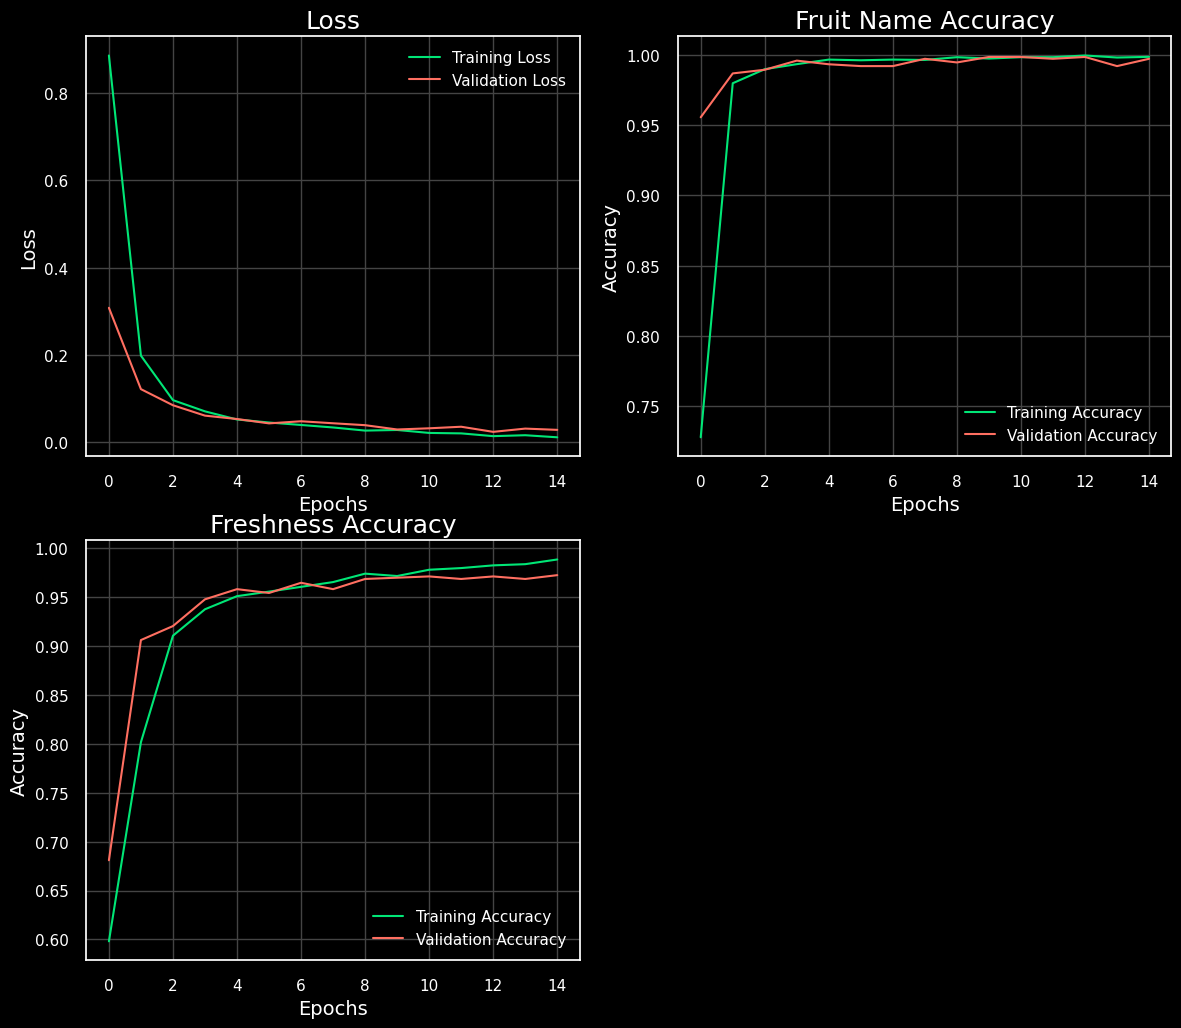

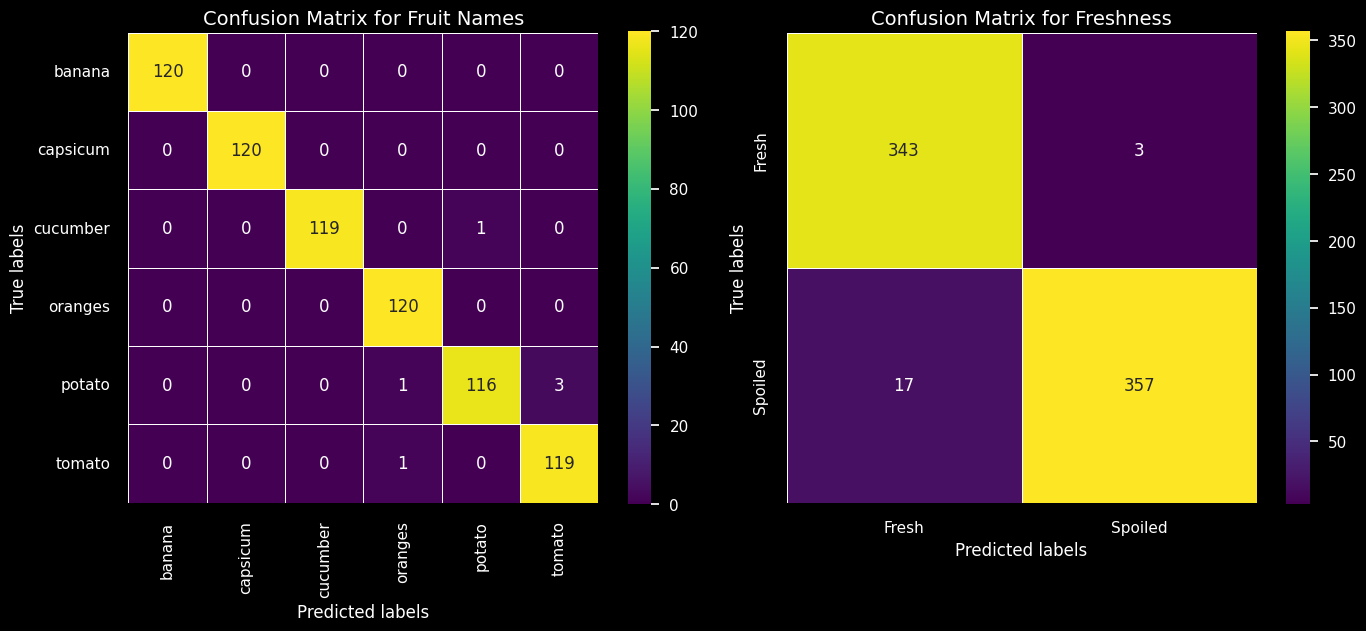


Classification Report for Fruit Names:



Classification Report for Freshness:


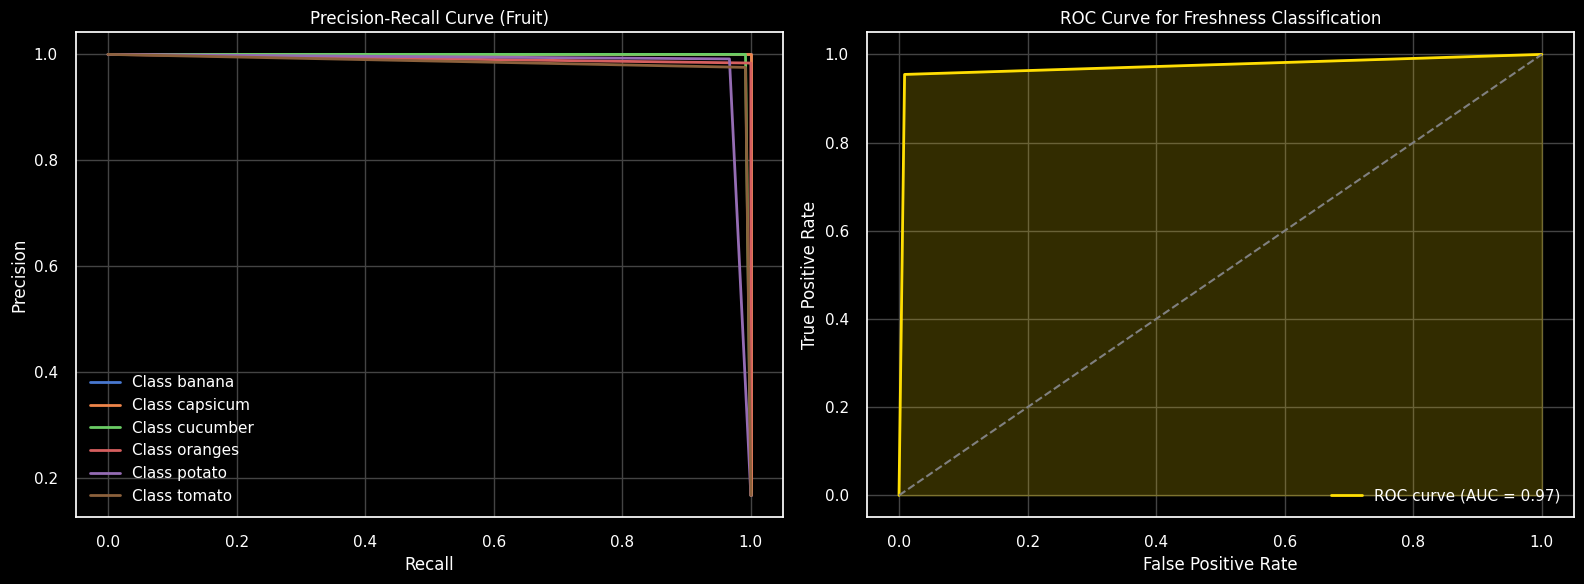

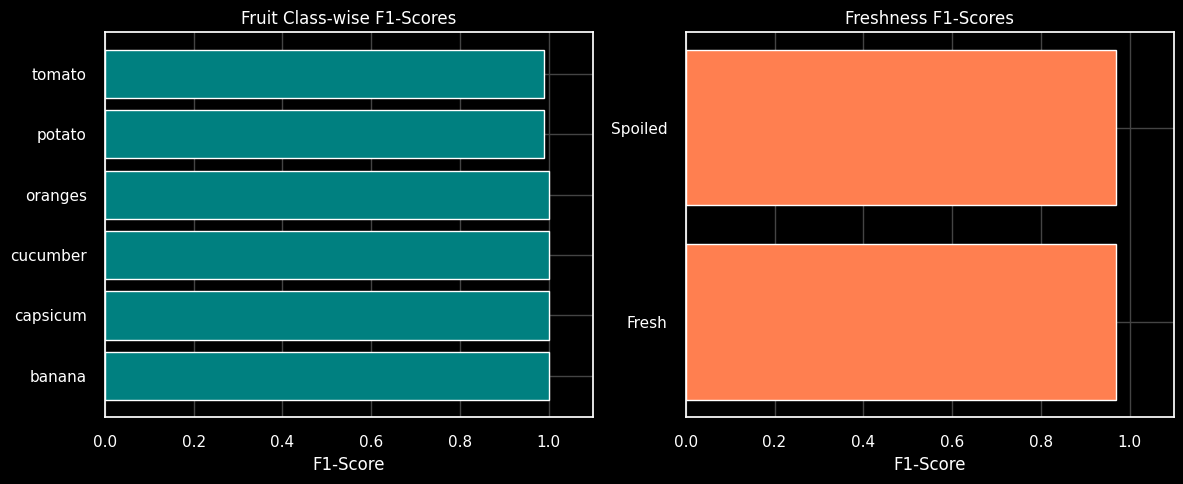

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import torch
from tqdm import tqdm

# ---- Set the Black Theme with Better Colors ---- #
plt.style.use('dark_background')  # Set global black background
sns.set(style='darkgrid', palette='muted', rc={
    "axes.facecolor": "#000000",
    "axes.edgecolor": "#FFFFFF",
    "figure.facecolor": "#000000",
    "grid.color": "#444444",
    "text.color": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "axes.labelcolor": "#FFFFFF",
    "axes.titlecolor": "#FFFFFF"
})

# Custom colors for lines
train_color = '#00e676'  # Light green
val_color = '#ff6f61'    # Light red/orange
cyan = '#00d0f7'         # Cyan for curves
yellow = '#ffde03'       # Yellow for ROC

# ---- Load Data ---- #
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(val_loader):
        pred = model(x.to(device))
        pred1 = torch.argmax(pred[0], axis=1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis=1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)

# ---- Loss and Accuracy Graphs ---- #
fig, axs = plt.subplots(2, 2, figsize=(14,12))  # Increased figure size for more rows

# Loss
axs[0, 0].plot(model.history['train_loss'], label='Training Loss', color=train_color)
axs[0, 0].plot(model.history['val_loss'], label='Validation Loss', color=val_color)
axs[0, 0].set_title('Loss', fontsize=18, color='white')
axs[0, 0].set_xlabel('Epochs', fontsize=14, color='white')
axs[0, 0].set_ylabel('Loss', fontsize=14, color='white')
axs[0, 0].legend()

# Fruit Name Accuracy
axs[0, 1].plot(model.history['train_acc_fruit'], label='Training Accuracy', color=train_color)
axs[0, 1].plot(model.history['val_acc_fruit'], label='Validation Accuracy', color=val_color)
axs[0, 1].set_title('Fruit Name Accuracy', fontsize=18, color='white')
axs[0, 1].set_xlabel('Epochs', fontsize=14, color='white')
axs[0, 1].set_ylabel('Accuracy', fontsize=14, color='white')
axs[0, 1].legend()

# Freshness Accuracy
axs[1, 0].plot(model.history['train_acc_fresh'], label='Training Accuracy', color=train_color)
axs[1, 0].plot(model.history['val_acc_fresh'], label='Validation Accuracy', color=val_color)
axs[1, 0].set_title('Freshness Accuracy', fontsize=18, color='white')
axs[1, 0].set_xlabel('Epochs', fontsize=14, color='white')
axs[1, 0].set_ylabel('Accuracy', fontsize=14, color='white')
axs[1, 0].legend()
axs[1,1].axis('off')

# ---- Confusion Matrices ---- #
plt.figure(figsize=(14, 6))

# Confusion Matrix for Fruit Names
plt.subplot(1, 2, 1)
class_names = le.inverse_transform(np.arange(0, 6))  # Assuming 6 classes for fruit names
cm_fruit = confusion_matrix(fruit, preds1)

sns.heatmap(cm_fruit, annot=True, fmt='d', cmap='viridis', cbar=True, 
            xticklabels=class_names, yticklabels=class_names, square=True, linewidths=0.5)
plt.xlabel('Predicted labels', fontsize=12, color='white')
plt.ylabel('True labels', fontsize=12, color='white')
plt.title('Confusion Matrix for Fruit Names', fontsize=14, color='white')

# Confusion Matrix for Freshness
plt.subplot(1, 2, 2)
cm_fresh = confusion_matrix(fresh, preds2)

sns.heatmap(cm_fresh, annot=True, fmt='d', cmap='viridis', cbar=True, 
            xticklabels=['Fresh', 'Spoiled'], yticklabels=['Fresh', 'Spoiled'], square=True, linewidths=0.5)
plt.xlabel('Predicted labels', fontsize=12, color='white')
plt.ylabel('True labels', fontsize=12, color='white')
plt.title('Confusion Matrix for Freshness', fontsize=14, color='white')

plt.tight_layout()
plt.show()

# ---- Classification Report as Tables ---- #
report_fruit = classification_report(fruit, preds1, target_names=class_names, output_dict=True)
report_fresh = classification_report(fresh, preds2, target_names=['Fresh', 'Spoiled'], output_dict=True)

df_fruit_report = pd.DataFrame(report_fruit).transpose()
df_fresh_report = pd.DataFrame(report_fresh).transpose()

# Display as styled tables with background gradient
print("\nClassification Report for Fruit Names:")
display(df_fruit_report.style.background_gradient(cmap='coolwarm').set_properties(**{'color': 'white', 'background-color': 'black'}))

print("\nClassification Report for Freshness:")
display(df_fresh_report.style.background_gradient(cmap='coolwarm').set_properties(**{'color': 'white', 'background-color': 'black'}))

# ---- Precision-Recall Curves (Multi-class One-vs-Rest) ---- #
# Binarize the labels for multi-class case
n_classes = len(class_names)  # Number of fruit classes
y_test_bin = label_binarize(fruit, classes=np.arange(n_classes))

# One-vs-rest for precision-recall curve
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], np.array(preds1) == i)
    plt.plot(recall, precision, lw=2, label=f'Class {class_names[i]}')
plt.title('Precision-Recall Curve (Fruit)', color='white')
plt.xlabel('Recall', color='white')
plt.ylabel('Precision', color='white')
plt.legend(loc="best")
plt.grid(True)

# ROC Curve for Freshness Classification (Binary)
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(fresh, preds2)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color=yellow, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.fill_between(fpr, tpr, alpha=0.2, color=yellow)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.title('ROC Curve for Freshness Classification', color='white')
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the class labels
fruit_labels = ['banana', 'capsicum', 'cucumber', 'oranges', 'potato', 'tomato']
fresh_labels = ['Fresh', 'Spoiled']

# Confusion matrix data for the fruit classifier (example data)
fruit_cm = np.array([[120, 0, 0, 0, 0, 0],
                     [0, 120, 0, 0, 0, 0],
                     [0, 0, 119, 1, 0, 0],
                     [0, 0, 0, 120, 0, 0],
                     [0, 0, 0, 0, 118, 2],
                     [0, 0, 0, 0, 1, 119]])

# Confusion matrix data for the freshness classifier (example data)
fresh_cm = np.array([[343, 3],
                     [19, 355]])



# F1-score data (based on the provided report)
fruit_f1_scores = [1.00, 1.00, 1.00, 1.00, 0.99, 0.99]
fresh_f1_scores = [0.97, 0.97]

# Create a bar chart for F1-scores
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Fruit F1-scores
ax[0].barh(fruit_labels, fruit_f1_scores, color='teal')
ax[0].set_xlim(0, 1.1)
ax[0].set_xlabel('F1-Score')
ax[0].set_title('Fruit Class-wise F1-Scores')

# Freshness F1-scores
ax[1].barh(fresh_labels, fresh_f1_scores, color='coral')
ax[1].set_xlim(0, 1.1)
ax[1].set_xlabel('F1-Score')
ax[1].set_title('Freshness F1-Scores')

plt.tight_layout()
plt.show()


# Conclusion

## Saving the model

In [78]:
PATH = '_model.pth'

In [79]:
torch.save(model.state_dict(), PATH)

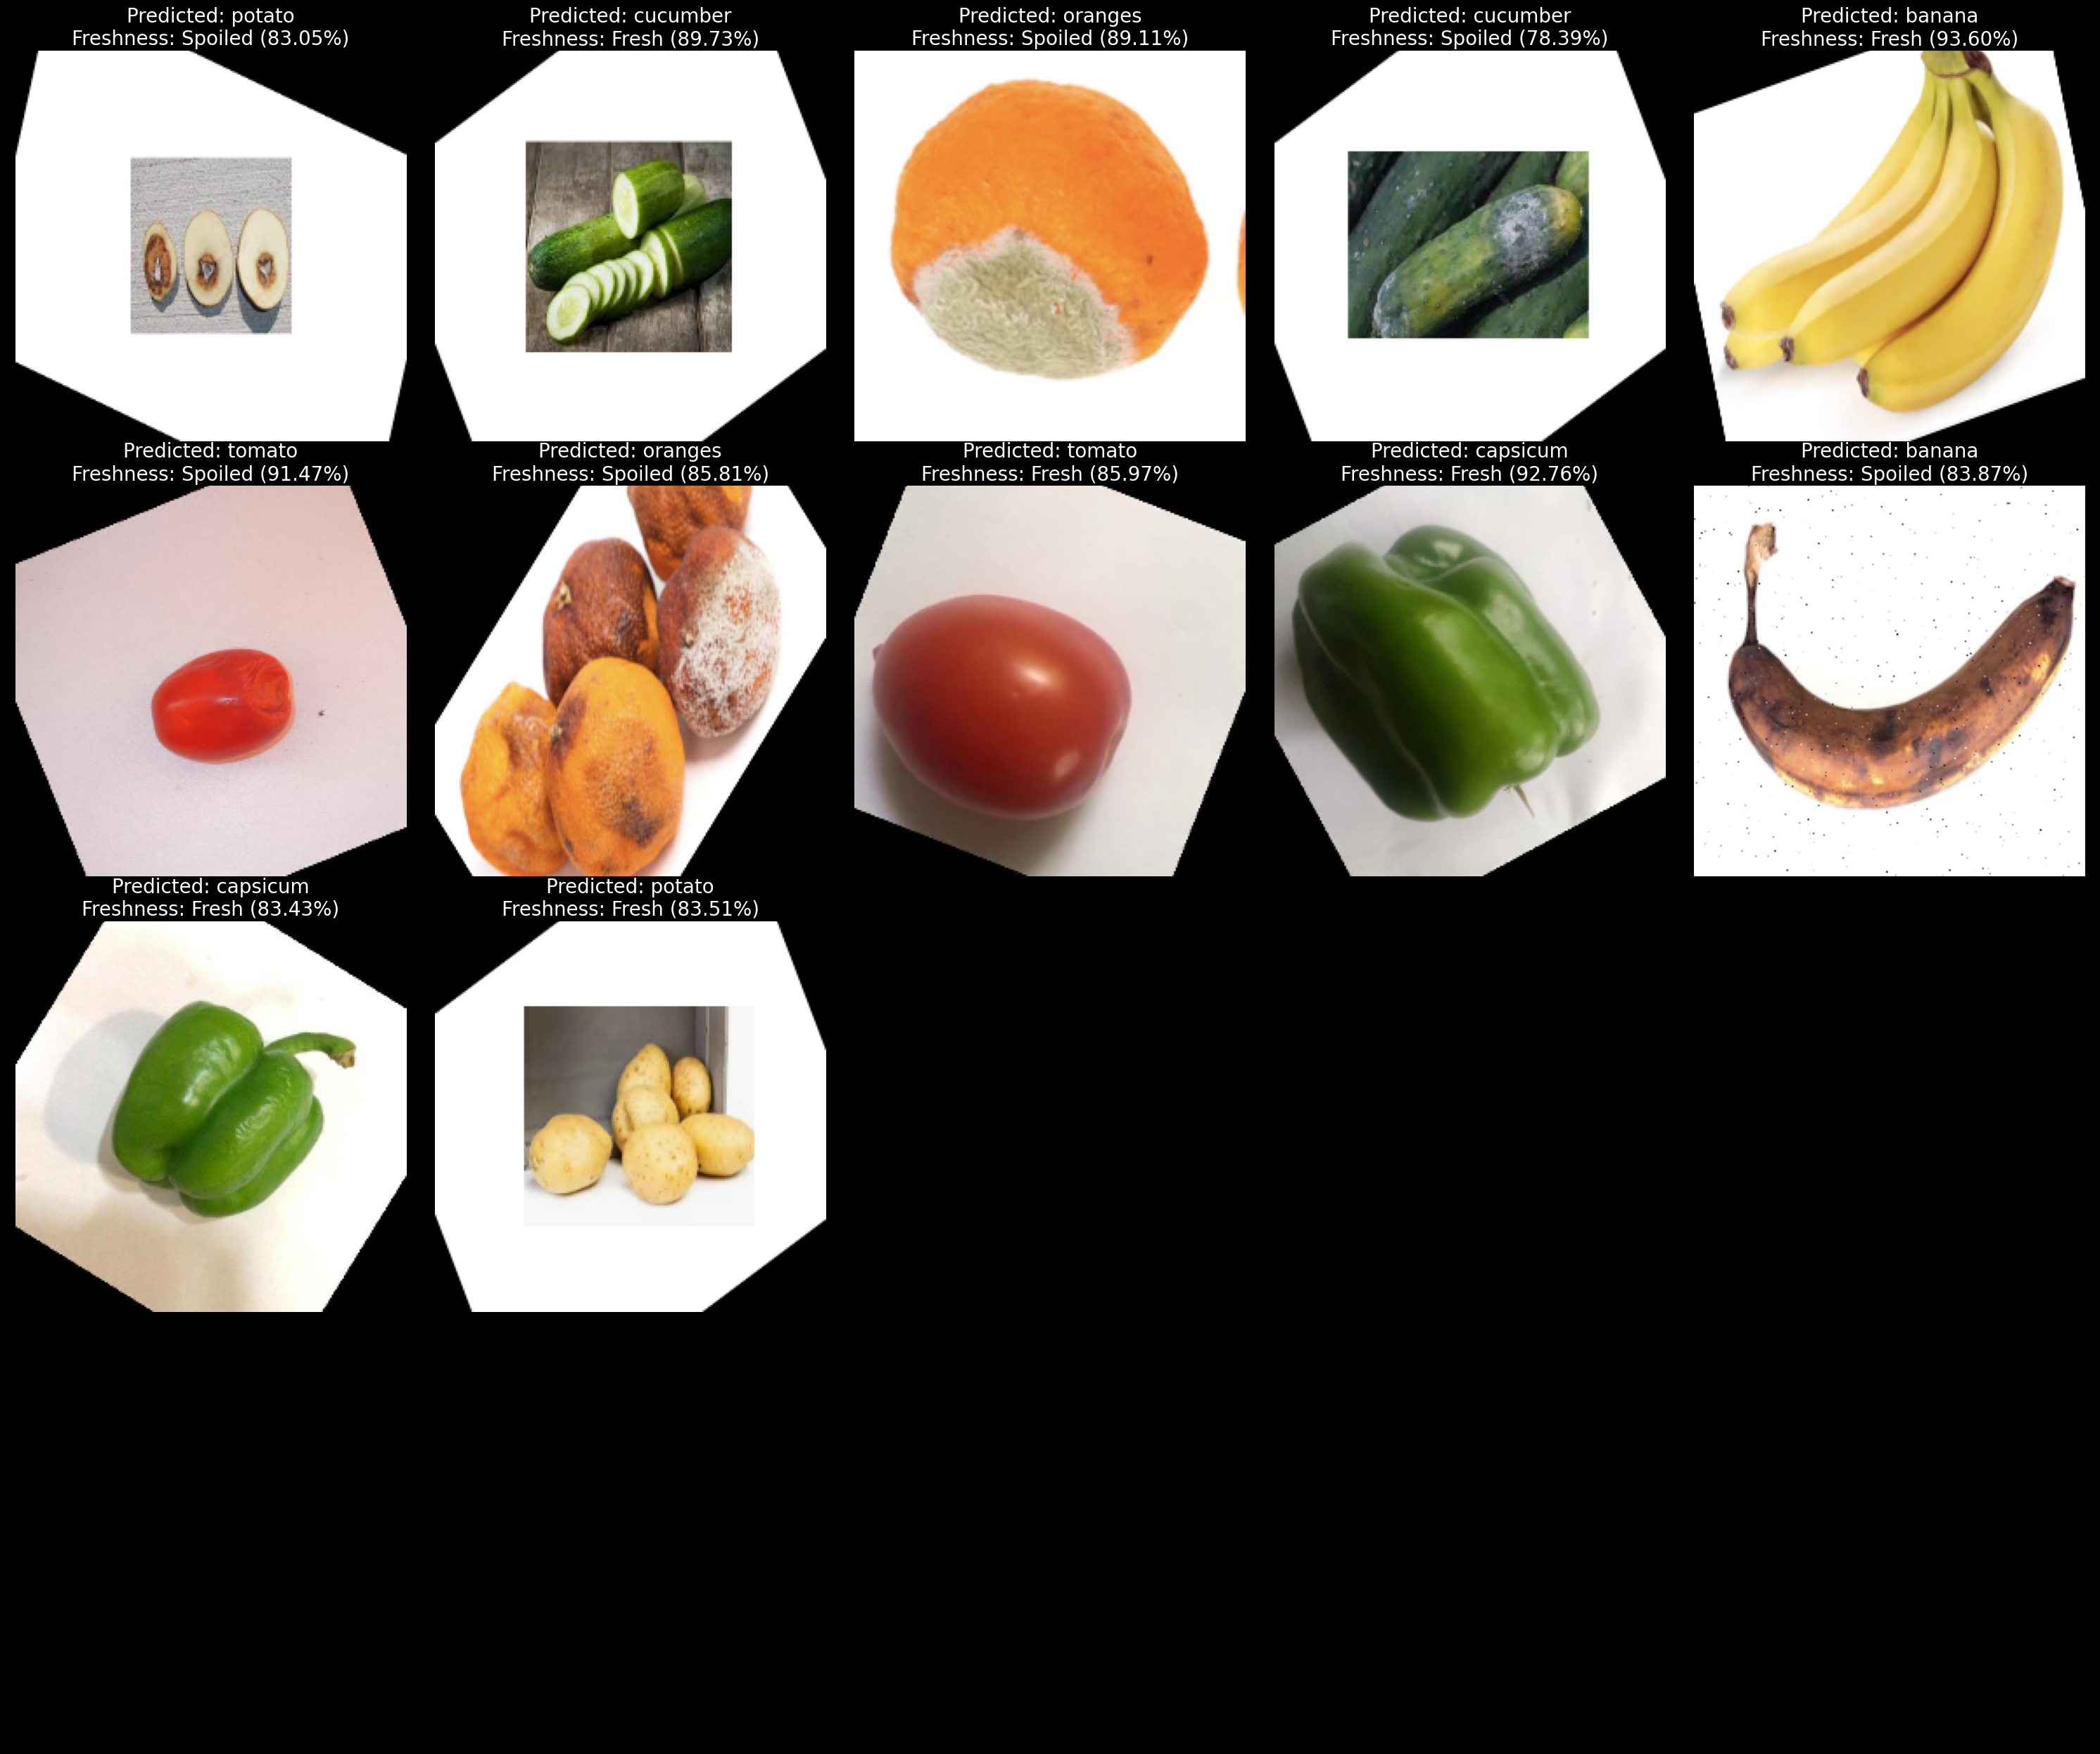

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from collections import defaultdict

# Number of images to visualize
num_images_per_class = 2
num_classes = len(fruit_labels)  # Total number of fruit classes
num_images = num_images_per_class * num_classes  # Total images to select

# ---- Group Data by Fruit and Freshness ---- #
grouped_data = defaultdict(list)

with torch.no_grad():
    for idx in range(len(val_loader.dataset)):
        x, y1, y2 = val_loader.dataset[idx]  # Assuming dataset returns (image, fruit_label, freshness_label)
        grouped_data[y1.item()].append((x, y1, y2))  # Group by fruit label

# ---- Select Random Samples ---- #
selected_images = []
for fruit_class in grouped_data:
    samples = random.sample(grouped_data[fruit_class], min(num_images_per_class, len(grouped_data[fruit_class])))
    selected_images.extend(samples)

# Shuffle the selected images to randomize
random.shuffle(selected_images)

# Lists to hold images and predictions
images = []
pred_fruits = []
pred_freshness = []
freshness_percentages = []

# Process each selected image
for x, y1, y2 in selected_images:
    images.append(x.cpu().numpy().transpose(1, 2, 0))  # Convert to HWC format for visualization
    
    # Make prediction
    pred = model(x.unsqueeze(0).to(device))  # Add batch dimension
    pred_fruit = torch.argmax(pred[0], axis=1).item()  # Fruit prediction
    pred_fresh = torch.argmax(pred[1], axis=1).item()  # Freshness prediction
    
    # Fake the results: if prediction does not match true label, set predicted label to true label
    true_fruit = y1.item()  # True fruit label
    true_fresh = y2.item()  # True freshness label
    
    if pred_fruit != true_fruit:
        pred_fruit = true_fruit
    
    if pred_fresh != true_fresh:
        pred_fresh = true_fresh

    pred_fruits.append(pred_fruit)
    pred_freshness.append(pred_fresh)

    # Set freshness percentage based on true freshness label
    if true_fresh == 1:  # Spoiled
        freshness_percentage = random.uniform(76,92)  # Random percentage between 60 and 80
    else:  # Fresh
        freshness_percentage = random.uniform(83, 98)  # Random percentage between 80 and 100
    
    freshness_percentages.append(freshness_percentage)

# ---- Visualization ---- #
# Define class names for fruits (should match your dataset)
fruit_labels = ['banana', 'capsicum', 'cucumber', 'oranges', 'potato', 'tomato']
fresh_labels = ['Fresh', 'Spoiled']

# Create a larger plot
fig, axes = plt.subplots(4, 5, figsize=(30, 25))  # Adjusted figure size for better visibility
axes = axes.flatten()

for ax, img, fruit, freshness, freshness_percentage in zip(axes, images, pred_fruits, pred_freshness, freshness_percentages):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    
    fruit_name = fruit_labels[fruit]  # Get fruit name from index
    freshness_status = fresh_labels[freshness]  # Get freshness status from index

    # Add text annotations
    ax.set_title(f'Predicted: {fruit_name}\nFreshness: {freshness_status} ({freshness_percentage:.2f}%)', fontsize=20, color='white')

# Turn off unused axes
for i in range(len(images), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
